Imports

In [1]:
import numpy as np
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sqlalchemy import create_engine
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load data

In [2]:
disk_engine = create_engine('sqlite:///lineData.db')
df = pd.read_sql_query('SELECT * FROM data', disk_engine)
df = df.dropna()
df.head(5)

,index,Date,Visitor,VisitorScore,HomeTeam,HomeScore,Line,Season,Favorite,HomeWinner,VisitorWinner,HL4,AL4,HomeWinPercentage,AwayWinPercentage
56,56,10/01/1978,Cincinnati Bengals,12,San Francisco 49ers,28,-2.5,1978,0,1,0,1,1,0.25,0.25
57,57,10/01/1978,Detroit Lions,14,Green Bay Packers,35,5.0,1978,1,1,0,3,1,0.75,0.25
58,58,10/01/1978,Houston Oilers,16,Cleveland Browns,13,5.0,1978,1,0,1,2,0,0.50,0.00
59,59,10/01/1978,Kansas City Chiefs,13,Buffalo Bills,28,3.0,1978,1,1,0,3,3,0.75,0.75
60,60,10/01/1978,New York Giants,20,Atlanta Falcons,23,-3.0,1978,0,1,0,2,4,0.50,1.00


In [3]:
#set the divider between training and testing data
dividerYear =2003
trainingDf = testDF = df[df["Season"] < dividerYear]
trainingDF = testDF.dropna()
testDF = df[df["Season"] >= dividerYear]
testDF = testDF.dropna()
#create design matrix and response data frames
y, X = dmatrices('HomeWinner ~ HomeWinPercentage + AwayWinPercentage + \
                    HL4 + AL4 + Favorite',trainingDF, return_type="dataframe")
yTest, XTest = dmatrices('HomeWinner ~ HomeWinPercentage + AwayWinPercentage + \
                    HL4 + AL4 + Favorite',testDF, return_type="dataframe")

In [4]:
print X.columns

Index([u'Intercept', u'HomeWinPercentage', u'AwayWinPercentage', u'HL4', u'AL4', u'Favorite'], dtype='object')


In [5]:
#flatten y, and yTest into 1D array for regression
y = np.ravel(y)
yTest = np.ravel(yTest)

In [6]:
# instantiate a logistic regression model, and fit with training data X and y
logReg = LogisticRegression()
logReg.fit(X,y)
#compute acuracy on training data
logReg.score(X,y)

0.53002170243549551

In [7]:
# examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(logReg.coef_)))

,0,1
0,Intercept,[0.0346415277286]
1,HomeWinPercentage,[-0.250951695404]
2,AwayWinPercentage,[0.342578395634]
3,HL4,[0.000939640081757]
4,AL4,[-0.00209436824447]
5,Favorite,[-0.191657229901]


In [8]:
#predict test data
preds = logReg.predict(XTest)

In [9]:
# generate class probabilities
probs = logReg.predict_proba(XTest)
print probs

[[ 0.5142757   0.4857243 ]
 [ 0.51970736  0.48029264]
 [ 0.41540006  0.58459994]
 ..., 
 [ 0.51960245  0.48039755]
 [ 0.5270577   0.4729423 ]
 [ 0.53274686  0.46725314]]


In [10]:
#compute some metrics
print metrics.accuracy_score(yTest, preds)
print metrics.roc_auc_score(yTest, probs[:, 1])

0.512673362028
0.508533424797


In [11]:
#entry i,j of confusion matrix is the number of observations in group i
#predicted to be in group j.
print metrics.confusion_matrix(yTest, preds)
print metrics.classification_report(yTest, preds)

[[690 407]
 [612 382]]
             precision    recall  f1-score   support

        0.0       0.53      0.63      0.58      1097
        1.0       0.48      0.38      0.43       994

avg / total       0.51      0.51      0.51      2091



In [12]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.53975904  0.5060241   0.51084337  0.52048193  0.49638554  0.51566265
  0.5253012   0.57004831  0.48309179  0.5531401 ]
0.522073802456


Area under the ROC curve : 0.508533


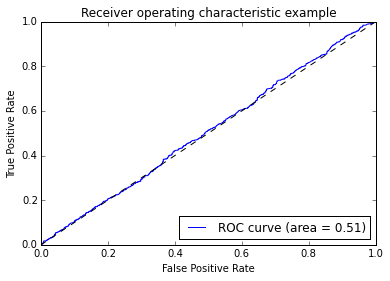

In [13]:
# Compute ROC curve and area the curve
#fpr = false positive rate, tpr = true positive rate
fpr, tpr, thresholds = metrics.roc_curve(yTest, probs[:, 1])
#area under curve for roc curve
roc_auc = metrics.auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc

# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
#add line of no-discrimination)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

So it looks like the logistic regression model is not appreciably better than random guessing.  No inefficiencies found in the market.